# Euler with ExaHyPE 2 
 
A very simple example which demonstrates how to configure a patch-based Finite Volume solver in Peano 4 through the ExaHyPE 2 interface/API. The solver simulates the simple Euler equations, i.e. we rely on the abstract first-order hyperbolic expression

$ \partial Q + \nabla ^T \cdot F(Q) = 0$

In this particular case, this formulation is


$ \frac{\partial}{\partial t} \begin{pmatrix}
\rho\\j\\\ E
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 






## Preparation before you start any ExaHyPE 2 work

Ensure you have configured with the options

     ./configure --enable-loadbalancing --enable-exahype --enable-blockstructured

I do recommend that you use some kind of parallelisation, too, but the options above are mandatory. Some old-ish compilers require you to tell them that we use C++17. In this case, please add

     CXXFLAGS="-std=c++17"
     
to the configure call.


## Preparation before you start the Jupyter notebook

To startup ExaHyPE, we need a couple of imports. To make them work, you will have to set your environment variables correctly before you launch the notebook or Python script respectively. On a standard checkout, this is

     export PYTHONPATH=../../../python

or

     export JUPYTER_PATH=../../../python

respectively. If you run the notebook locally, you might have to set both pathes. If you prefer to run this example without the browser (might be faster), use the ipython3 command:





In [ ]:
import os
import peano4
import exahype2

In [ ]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use (it is examples::exahype2::euler here), we have to give it a name. There are a few more options that we omit here.

In [ ]:
project = exahype2.Project( ["examples", "exahype2", "euler"], "finitevolumes" )

## A Finite Volumes solver

Our first step is to use a Finite Volumes solver. So we add this solver to the project. An ExaHyPE mesh can carry multiple solvers at the same time, but we only use one here.

In [ ]:
patch_size     = 9
unknowns       = 5
auxiliary_variables = 0   # This could be something alike material parameters. Not required for Euler.
time_step_size = 0.0001
max_h          = 0.2
min_h          = max_h
solver = exahype2.solvers.fv.rusanov.GlobalAdaptiveTimeStep(
  "Euler", patch_size, unknowns, auxiliary_variables, min_h, max_h, time_step_size,
  flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  eigenvalues = exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  refinement_criterion=exahype2.solvers.fv.PDETerms.User_Defined_Implementation
)
project.add_solver( solver )

## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [ ]:
dimensions = 2

terminal_time = 0.01
time_in_between_two_snapshots = max(time_step_size,terminal_time/100)  # try to do 100 snapshots


if dimensions==2:
  project.set_global_simulation_parameters(
    dimensions,  [0.0,0.0],  [1.0,1.0],
    terminal_time,                        # end time
    0, time_in_between_two_snapshots,     # snapshots
    [True, False]                         # periodic BCs in x-direction 
  )
else:
  project.set_global_simulation_parameters(
    dimensions, [0.0,0.0,0.0], [1.0,1.0,1.0],
    terminal_time,                     # end time
    0.0, time_in_between_two_snapshots # snapshots
  )


## Generate a Peano 4 project

ExaHyPE's Python API does not really "do" something itself. It is a front-end to create and configure a Peano project. Peano in turn has its own Python API. In principle that allows us to use ExaHyPE 2 as a very high level code generator that we later on tweak. We can even use the outcome to inject further functionality that has never been supported by ExaHyPE 2 yet is available in Peano.

For the time being, none of these things is requires. We therefore simply ask ExaHyPE's API to give us a Peano project. This project is then told to generate the "real" C++ code and to translate. Every system will have a bespoke configuration, i.e. its own set of compilers, include paths, ... All of these ingredients have been chosen and tailored when we issued the configure script. Peano's Python API can parse the outcome of the configure instruction and use the same settings for the ExaHyPE/Peano project, too.

The generation can build up reasonably big data structures. If you work on a low-spec machine, you thus might want to tell the generate command to throw away all generated data after the C++ code has been built up.

In [ ]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

I first cleanup some local files. Would be a pity to become confused through a lot of output from a previous run.

In [ ]:
peano4_project.generate( throw_away_data_after_generation=False )

In [ ]:
!ls

To actually implement our PDE, we have to open Euler.cpp in a text editor of our choice and add in the flux functions. We also add some code snippets to set our initial conditions as well as boundary conditions.

<pre>

void examples::exahype2::euler::Euler::adjustSolution(
  double Q[5],
  const tarch::la::Vector<Dimensions,double>&  x,
  const tarch::la::Vector<Dimensions,double>&  h,
  double                                       t
) {
  // see code in Euler.cpp
}

void examples::exahype2::euler::Euler::eigenvalues(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       lambda[5]
) {
  [...]
}

void examples::exahype2::euler::Euler::flux(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       F[5]
) {
  logTraceInWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
  [...]
  logTraceOutWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
}

void examples::exahype2::euler::Euler::boundaryConditions(
  double                                       Qinside[5],
  double                                       Qoutside[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal
) {
  logTraceInWith4Arguments( "boundaryConditions(...)", faceCentre, volumeH, t, normal );
  Qoutside[0] = Qinside[0];
  Qoutside[1] = Qinside[1];
  Qoutside[2] = Qinside[2];
  Qoutside[3] = Qinside[3];
  Qoutside[4] = Qinside[4];
  logTraceOut( "boundaryConditions(...)" );
}
</pre>

This particular solver offers several implementation variants. It also can be fed with different memory allocation schemes for any dynamic memory allocation. Not all of them are C++ standard compliant, i.e. Clang for example might refuse to accept them. If you have use the routines below, you'll have to regenerate teh Peano4 project.

In [ ]:
# The default
#solver.set_implementation(
#  use_split_loop  = False,
#  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.HeapThroughTarch
#)

# Something that's way faster on my machine but not C++ compatible (only C99) - Clang might refuse to compile it
solver.set_implementation(
  use_split_loop  = False,
  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.CallStack
)

# A vectorised version with more memory scattering, but usually faster
#solver.set_implementation(
#  use_split_loop  = True,
#  memory_location = peano4.toolbox.blockstructured.ReconstructedArrayMemoryLocation.CallStack
#)

With all project content generated and befilled with semantics, we can finally translate the code. Note that the above steps have actually produced a Makefile in our ExaHyPE 2 project folder. So we can either translate the project through the notebook, or we can switch to a terminal and invoke the translation manually.

Take care with the translation process if you want to use something fancy that is not active by default. If you have particular modules loaded or environment variables set, then all of these are required before you launch the notebook. On my own system, I need for example

<pre>
source /opt/intel/bin/iccvars.sh intel64
source /opt/intel/itac/2020.0.015/bin/itacvars.sh
source /opt/intel/impi/2019.6.166/intel64/bin/mpivars.sh
</pre>

to use the Intel toolchain. I experienced issues with notebooks where compile errors had not been displayed. Have a look at the terminal: It seems that cerr is not always piped into the notebook window. If that doesn't help, the only remaining option is to execute the whole notebook via ipython3.

In [ ]:
parallel_builds = 12   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                       # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

# If you don't like to use Peano's wrapper, simply call make. ExaHyPE 2/Peano 4 rely on plain makefiles:
# !make

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [ ]:
#peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )
peano4_project.run( pipefile = "output.txt", rebuild_if_required=False )

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [1]:
import os
import peano4
import exahype2

import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", "Euler", verbose=True )

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
Numpy/mpmath is not available, not loading dg
Numpy/mpmath is not available, not loading aderdg
ExaHyPE 2 (C) www.peano-framework.org
parse output.txt
triggered plot at 0.10802642s
started new time step at 0.220771964s
started new time step at 0.29141276299999996s
started new time step at 0.35774986700000005s
started new time step at 0.422924745s
started new time step at 0.487648484s
started new time step at 0.555475195s
started new time step at 0.619856069s
started new time step at 0.7671679499999999s
started new time step at 0.8454967330000001s
started new time step at 0.915222904s
started new time step at 1.029198529s
started new time step at 1.102006365s
started new time step at 1.180817148s
started new time step at 1.266285258s
started new time step at 1.35148326s
started new time step at 1.4223682239999997s
started new time step at 1.489185808s
started new time step at 1.556555658s
started new time step at 

started new time step at 196.772149539s
started new time step at 196.848900986s
started new time step at 196.917428068s
started new time step at 197.004516863s
started new time step at 197.086759518s
started new time step at 197.167442769s
started new time step at 197.234252885s
started new time step at 197.30103148199998s
started new time step at 197.371583944s
started new time step at 197.451191782s
started new time step at 197.539584803s
started new time step at 197.612624657s
started new time step at 197.68246887s
started new time step at 197.75134589700002s
started new time step at 197.81958654699997s
started new time step at 197.88788458000002s
started new time step at 197.95620628400002s
started new time step at 198.024135165s
started new time step at 198.09226184s
started new time step at 198.159572896s
started new time step at 198.234330876s
started new time step at 198.32925019200002s
started new time step at 198.400091454s
started new time step at 198.472902463s
started new 

started new time step at 388.116294536s
started new time step at 388.181111481s
started new time step at 388.24968182400005s
started new time step at 388.31443775599996s
started new time step at 388.379363032s
started new time step at 388.44397816500003s
started new time step at 388.50900532700007s
started new time step at 388.57381501s
started new time step at 388.638521199s
started new time step at 388.70424114499997s
started new time step at 388.769028902s
started new time step at 388.83391513500004s
started new time step at 388.898511289s
started new time step at 388.96371362400004s
started new time step at 389.028568465s
started new time step at 389.09338213300003s
started new time step at 389.158017018s
started new time step at 389.22260856099996s
started new time step at 389.287189491s
started new time step at 389.355739256s
started new time step at 389.420286652s
started new time step at 389.484756372s
started new time step at 389.54945743s
started new time step at 389.61372227

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

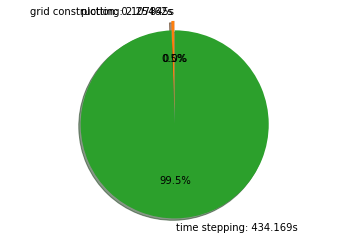

In [2]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

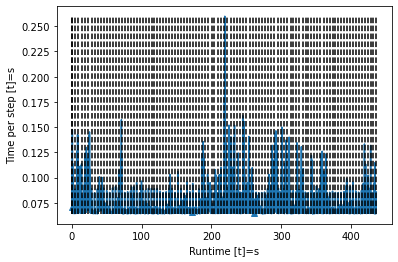

In [4]:
exahype2.postprocessing.plot_runtime_per_time_step(performance_data)

## Inspecting output files via Paraview

We have different ways how to visualise output. See the guidebook for details. No matter which route we follow, we always first have to find out which files we have, as we need the filenames to trigger the postprocessing/vis. Per solver, we should have a file solution-XXX.peano-patch-file. The XXX is the solver name we have specified above.

In [ ]:
!ls

### Explicit conversion

This is an explicit, one-off conversion via an executable invocation. You can trigger this via the command line, i.e. via a manual invocation of the convert script. Alternatively, you can use Peano's Python convert wrapper:

In [ ]:
import peano4.visualisation

peano_output_files = "solution-Euler"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()


Now you can invoke Paraview or VisIt in a separate window and study the outcome. Alternatively, you can use Paraview with its Paraview scripting environment. I select "Tools - Start Trace" and do my postprocessing. Upon hitting "Tools - End Trace" I obtain a Python script to render my stuff that I can insert here. You will have to modify it slightly, but the comments how to do so are all dumped by Paraview.

Alternatively, you can use the ipyparaview plugin as yet find it at https://github.com/Kitware/ipyparaview.git. The description of this one reads really cool, but I haven't managed yet to install it on my machine.

### Other approaches

Once you have converted data into vtk/vtu (see explicit conversion, e.g.), you can load the data dump into Paraview. Alternatively, you can directly display Peano's patch files within paraview. For this, you have to use Paraview's Python plugin. The details are described in the guidebook. The following lines however work for me:

<pre>
import peano4.visualisation
data = peano4.visualisation.render_dataset( \
  "solution-Euler.peano-patch-file", \
  display_as_tree=False, \
  filter=[peano4.visualisation.ExtractFineGridFilter()], \
  dataset_number=0, identifier="EulerQ" \
)
tp = TrivialProducer()
tp.GetClientSideObject().SetOutput(data)
Show(tp)
</pre>

A more sophisticated version loads all the snapshots in one go, but the actual display as movie does not work (yet):

<pre>
import peano4.visualisation
for i in range(0,11):
  data = peano4.visualisation.render_dataset( \
    "solution-Euler.peano-patch-file", \
    display_as_tree=False, \
    filter=[peano4.visualisation.ExtractFineGridFilter()], \
    dataset_number=i, identifier="EulerQ" \
  )
  tp = TrivialProducer()
  tp.GetClientSideObject().SetOutput(data)
  Show(tp)
</pre>

I have one more version which is kind of useful, as you can step through the snapshots manually via the select_dataset routine:

<pre>
import peano4.visualisation
visualiser = peano4.visualisation.Visualiser("solution-Euler.peano-patch-file")
visualiser.append_filter(peano4.visualisation.ExtractFineGridFilter())
visualiser.display()

visualiser.select_dataset(0)
visualiser.select_dataset(1)

visualiser.select_dataset(20)


visualiser.write_vtu "test" )

visualiser.write_vtu_time_series()
</pre>


## Working with a symbolic flux function

Without a doubt, it is cumbersome to implement the fluxes et al manually. In ExaHyPE 2, I give users the opportunity to inject code snippets into the solver generation, i.e. instead of asking ExaHyPE and Peano to give you a C++ template that you then befill with content, you can add in content (copy n paste) through the Python interface. This content in turn can stem from SymPy, when we use SymPy's C code generation. This code generation has to stick to some contentions, but ExaHyPE 2 provides an API/SymPy layer for this:

In [ ]:
project.remove_all_solvers()  # clean-up
my_solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSize("SymbolicEuler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation)
project.add_solver( my_solver )

The above snippet is exactly the same thing we've done before, but this time we keep a reference to the solver. Next, we construct our PDE terms.

In [ ]:
import sympy
import exahype2.sympy.FirstOrderConservativePDEFormulation

pde = exahype2.sympy.FirstOrderConservativePDEFormulation(unknowns = 5,auxiliary_variables=0,dimensions = 3)

#
# Give entries in input vector symbolic names. We first declare the constant
# gamma. Then we tell the solver how we would like to name the Q 
# entries
#
gamma = sympy.symbols( "gamma")
rho   = pde.name_Q_entry( 0, "rho" )    # first scalar is rho
j     = pde.name_Q_entries( 1, 3, "j" ) # entries 1-3 (C counting style) holds j vector
E     = pde.name_Q_entry( 4, "E" )      # energy

#
# Define the equation system
#
p = (gamma - 1 ) * (E-1/2 * exahype2.sympy.dot(j,j) / rho)

pde.F[0,:]   = j
pde.F[1:4,:] = 1/rho * exahype2.sympy.outer(j,j) + p * sympy.eye(3)
pde.F[4,:]   = 1/rho * j * (E+p)

c = sympy.sqrt( gamma * p /rho )
pde.eigenvalue[0] = [ j[0]/rho - c, j[1]/rho - c, j[2]/rho - c ]
pde.eigenvalue[1] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[2] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[3] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[4] = [ j[0]/rho + c, j[1]/rho + c, j[2]/rho + c ]

pde.substitute_expression( gamma, 1.4 )


Let's display the outcome in a way we can read it:

In [ ]:
from IPython.display import Latex
latex_representation = pde.LaTeX()
latex_representation = latex_representation.replace( "rho", "\\rho" )
Latex( latex_representation )


Now we add these routines to our solver. When Peano creates all user code the next time, it will automatically take the functions phrased via SymPy. You can, obviously, mix, i.e. phrase some things (such as the flux) via SymPy and leave others. You'll then get C++ stubs that you have to implement yourself.

In [ ]:
volume_centre = sympy.symbols( "volume_centre")

volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 )
#volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 + (0.5-pde.x[2])**2 )

pde.initial_values[0] = 0.1  # rho
pde.initial_values[1] = 0
pde.initial_values[2] = 0
pde.initial_values[3] = 0
pde.initial_values[4] = sympy.Piecewise( (1.0, volume_centre<0.1), (0.0,True) )


In this simple case, we literally everything symbolic, so there's no need for any manual implementation. The only thing we have to do is to tell the PDE that we actually use only two dimensions in this test case. This is kind of a hack - in most real codes you won't first phrase your PDE in 3d and then "downcast" it to 2d. But it does the job here: 

In [ ]:
pde.dimensions=2
my_solver.set_implementation(
  flux=pde.implementation_of_flux(),
  eigenvalues=pde.implementation_of_max_eigenvalue(use_absolute_values=True),
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC(),
  initial_conditions=pde.implementation_of_initial_conditions(invoke_evalf_before_output=False),
  refinement_criterion=exahype2.solvers.fv.PDETerms.Empty_Implementation
)
my_solver.set_plot_description( pde.unknown_identifier_for_plotter() )

In [ ]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

In [ ]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

We rerun the code to be able to quantify how expensive the symbolic reformulation is.

In [ ]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-symbolic.txt", rebuild_if_required=False )

In [ ]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-symbolic.txt", verbose=False )
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

In [ ]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Parallelisation

The parallelisation in ExaHyPE 2 is relatively simple. 

- You have to ensure that configure is called with multithreading and/or MPI support. I recommend never to run MPI without multicore parallelisation. Once you have configured it appropriately, please rebuild all libraries.
- You next have to add a load balancing to your Python project. This will then tell your application to exploit all resources. My default load balancing usually a good starting point. 

In [ ]:
load_balancing_quality = 0.9  # quantifies computational ill-balance that we are happy accept
project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(" + str(load_balancing_quality) + ")" )
#project.set_load_balancing( "toolbox::loadbalancing::TwoLevelGreedy" )

We now have to rebuild the application and then rerun the code:

In [ ]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


In [ ]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

I found that this sometimes does not work (on my Ubuntu system - OpenSUSE was fine). In this case, simply call make and the run on the command line. Ensure you pipe the run's output to output.txt.

In [ ]:
!ls

We see that we get a lot of new files. The code does partition the domain now. Each subdomain writes its own snapshot if you trigger a dump. So, overall, the number of output files scales with the number of threads/ranks used.

In [ ]:
peano4_project.run( ["--threads","12"], prefix = ["mpirun", "-n", "1"], pipefile = "output-parallel.txt", rebuild_if_required=False )

In [ ]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output-parallel.txt", verbose=False )

In [ ]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

We should see that the time spent int the time stepping has gone down. Plotting is slightly faster in most cases, but it depends on your disk speed. This usually is the limiting factor here. The grid construction becomes more expensive as we do quite some load balancing here. To see exactly this load balancing, we exploit the fact that Peano's load balancing toolbox comes along with some scripts of its own that allow us to analyse the decomposition:

In [ ]:
import sys
sys.path.append( "../../../src/toolbox/loadbalancing/")
import plot_load_distribution

In [ ]:
plot_load_distribution.plot( "output-parallel.txt", verbose=False, plot_remote_cells=False, sum_per_rank=False )

In [ ]:
plot_load_distribution.plot_trees_per_rank( "output-parallel.txt", verbose=False )

For most setups, the trees that are deployed to the cores will be ill-balanced. This is a natural consequence of the tree structure. This implies that we cannot exploit the cores effectively with trees only - we have to use tasks, too. For this, we however need another solver:

# Using enclave tasking

Enclave tasking is a technique where a timestep is broken up into two grid traversals, but the first one focuses on the computation along cells that are time-critical. The other operations are spawned as background tasks. A second traversal then gathers the outcomes of these background tasks, i.e. is, more or less, a sole tidy-up sweep. I remove the solvers first and add this new type of enclave solver. I give it the same name as our first solver. The enclave solver is a cousin to the plain one and uses exactly the same signature. We have manually written some flux and eigenvalue functions before. These one thus will then automatically be used here: We specity a solver called Euler, the toolkit will create all solver infrastructure, but it will not overwrite anything called Euler.cpp for or Euler.h as it assumes that you've already written some user-specific code. So this implementation is then used for the enclave solver. As I wrote: Works only as plain and enclave solver have exactly the same signature.

In [ ]:
project.remove_all_solvers()
project.add_solver( exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
  "Euler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
  flux=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  plot_grid_properties=True
))

In [ ]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


In [ ]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

In [ ]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-enclave.txt", rebuild_if_required=False )

We re-evaluate the runtime with the new run. It is only the runtime that will have changed - the switch to another solver will not affect the load balancing (as we work with the same grid). The code however will now use twice as many steps.

In [ ]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-enclave.txt", verbose=False )

In [ ]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

In [ ]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

In [ ]:
import peano4.visualisation

convert = peano4.visualisation.Convert( "solution-Euler", True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

convert = peano4.visualisation.Convert( "grid-Euler", True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()

# ADER-DG

To run ADER-DG, we need to import all of our libs and create a project. This worksheet has done so above, but I repeat these core steps here for convenience.

In [ ]:
import os
import peano4
import exahype2

project = exahype2.Project( ["examples", "exahype2", "euler"], "finitevolumes" )

We create an ADER-DG solver along the lines of the Finite Volume scheme. There's not really a conceptional difference:

In [ ]:
order          = 2
unknowns       = 5
auxiliary_variables = 0   # This could be something alike material parameters. Not required for Euler.
time_step_size = 0.0001
max_h          = 0.2
min_h          = max_h

solver = exahype2.solvers.aderdg.NonFusedGenericRusanovFixedTimeStepSize(
  "ADERDGEuler", order, unknowns, auxiliary_variables, exahype2.solvers.aderdg.Polynomials.Gauss_Legendre, 
  min_h, max_h, time_step_size
)
solver.set_plot_description( "0: Density, (1,2,3): Velocities, 4: Energy")


project.add_solver( solver )



In [ ]:
dimensions = 2

terminal_time = 0.1
time_in_between_two_snapshots = max(time_step_size,terminal_time/10)  # try to do 10 snapshots

if dimensions==2:
  project.set_global_simulation_parameters(
    dimensions,  [0.0,0.0],  [1.0,1.0],
    terminal_time,                        # end time
    0, time_in_between_two_snapshots,     # snapshots
    [True, False]                         # periodic BCs in x-direction 
  )
else:
  project.set_global_simulation_parameters(
    dimensions, [0.0,0.0,0.0], [1.0,1.0,1.0],
    terminal_time,                     # end time
    0.0, time_in_between_two_snapshots # snapshots
  )

In [ ]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

In [ ]:
!make -j12

## Runge-Kutta DG

This has yet to be written.

## Troubleshooting

### Ubuntu 

I had issues with matplotlib on Ubuntu (all worked fine on OpenSUSE right from the start). The snippet below resolved that problem. I had to restart the notebook however.

<pre>
import sys  
!{sys.executable} -m pip install --user matplotlib
</pre>

### Python version

If you get errors within Peano or ExaHyPE then you might have spotted a bug there. Before you dive into details, please crosscheck which Python version you run. I require Python 3!

In [ ]:
from platform import python_version

print(python_version())

### Matplotlib generations

In some of my parallel performance analysis scripts, I use the statements

plt.yscale( "log", base=2 )

I think this is a change in the matplotlib signatures, i.e. old codes require you to write basex, while this is deprecated and now should be base. So don't be confused. Maybe update matplotlib.

### Paraview 

If you Paraview display does not work, it might be that you lack the right packages and environment variables. 

On Ubuntu I had to install the package python3-paraview on top of Paraview. 

Furthermore, the PYTHONPATH has to point to the python3.7/site-packages subdirectory. I use for example

export PYTHONPATH=../../../python:/opt/ParaView-5.7.0-MPI-Linux-Python3.7-64bit/lib/python3.7/site-packages
    
before I start the Jupyter lab.